# CLT and prediction examples

In [17]:
library(tidyverse)
library(gridExtra)
library(plotly)
options(repr.plot.width=12, repr.plot.height=10)

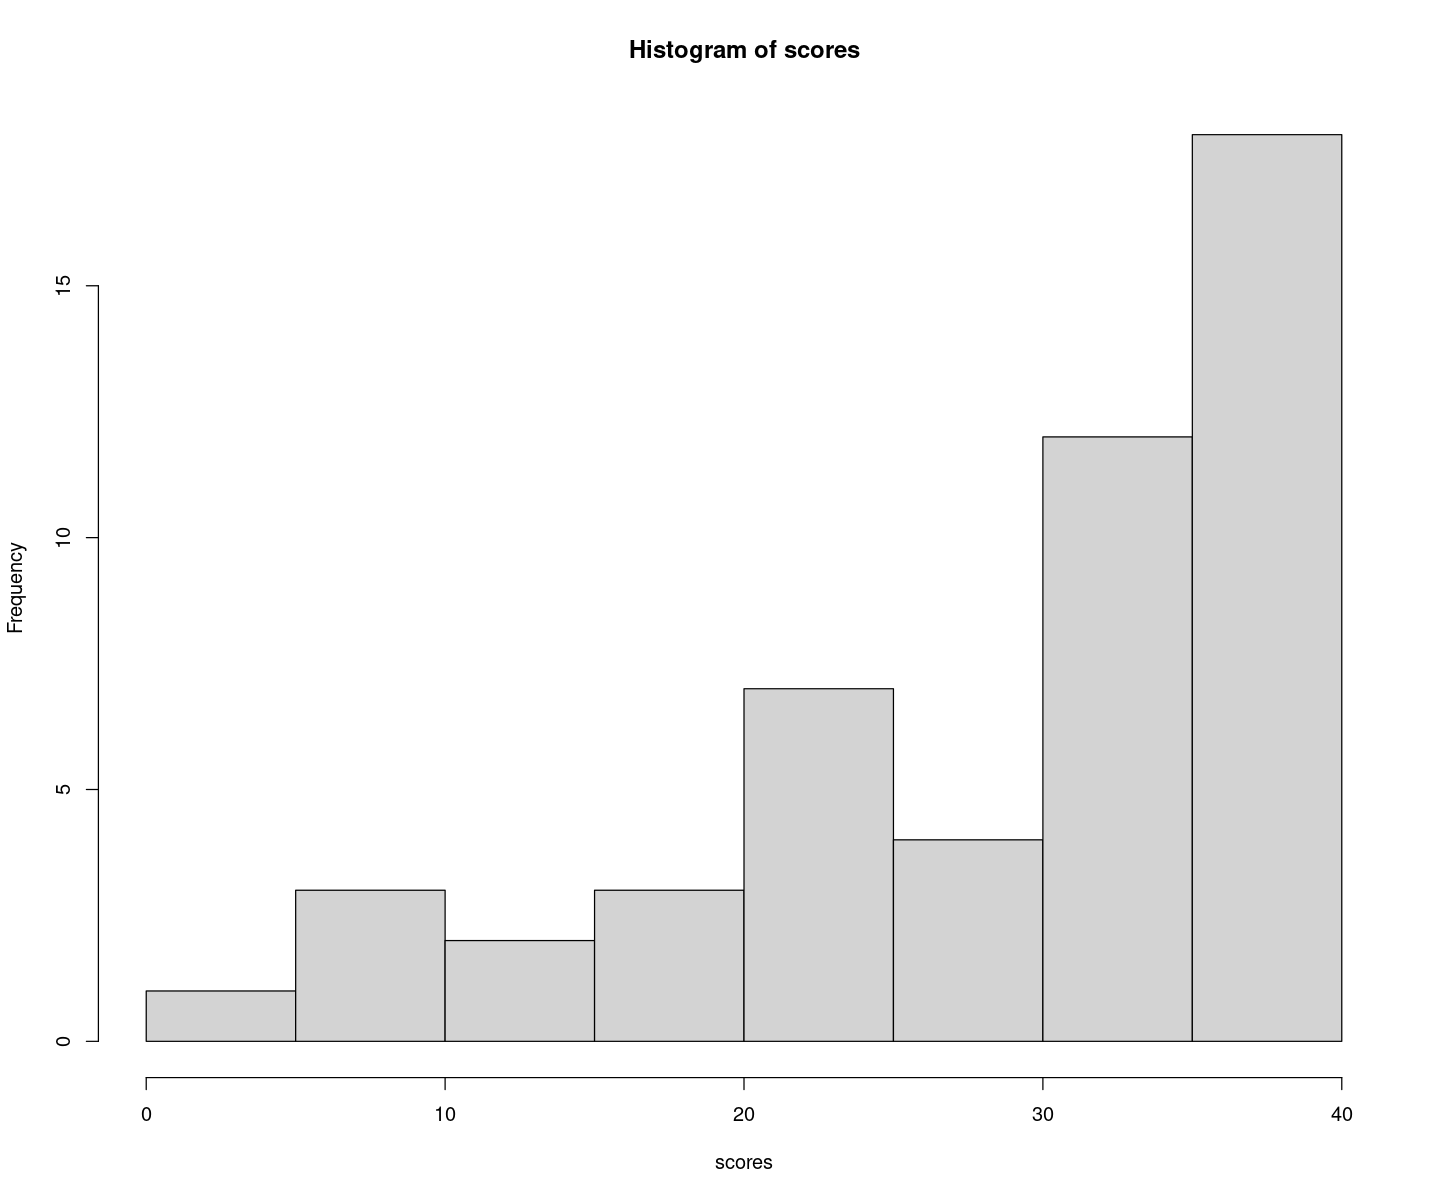

In [2]:
scores <- read.csv("final_exams_spring24.csv")$Total
n_obs <- length(scores)
ybar <- mean(scores)

hist(scores) 

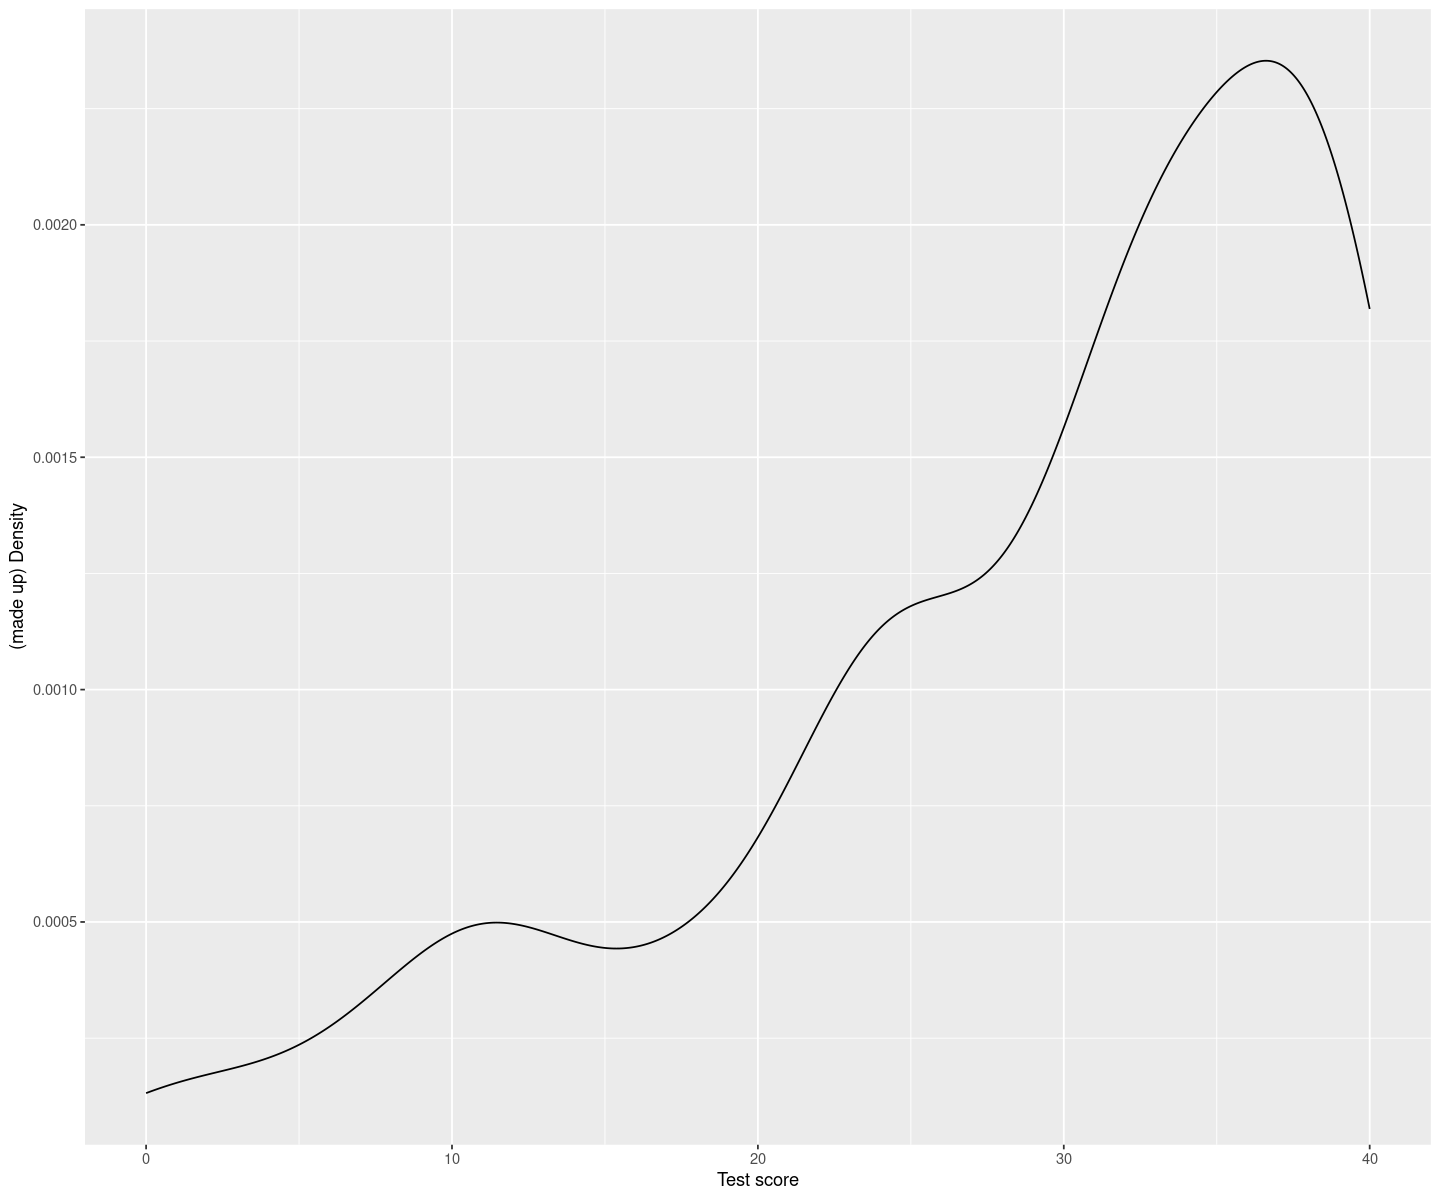

In [3]:
bandwidth <- 3
eval_score_dens <- function(x) {
  return(mean(dnorm(x- scores, sd=bandwidth)))
}

score_grid <- seq(0, 40, length.out=1000)
score_dens <- sapply(score_grid, eval_score_dens)
score_dens <- score_dens / sum(score_dens)
score_df <- cumsum(score_dens) / sum(score_dens)

# Look at my (made-up) density
ggplot() +
    geom_line(aes(x=score_grid, y=score_dens)) + 
    xlab("Test score") + ylab("(made up) Density")

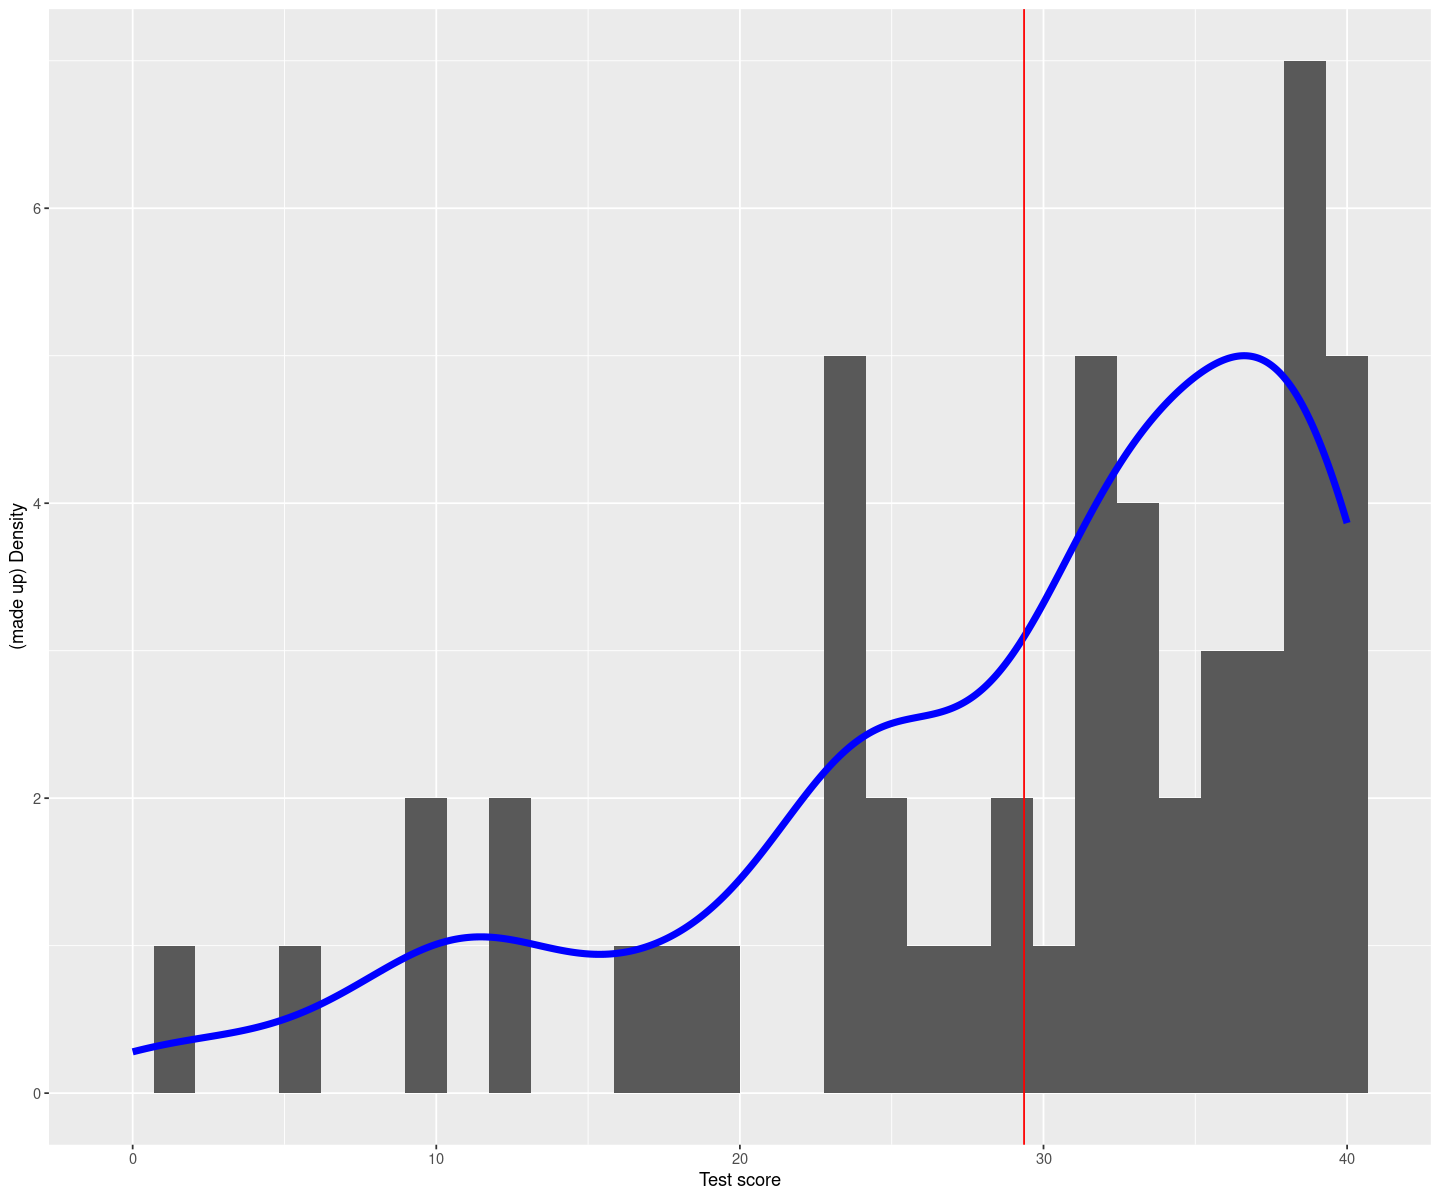

In [4]:
score_dist_df <- data.frame(score=score_grid, score_dens=score_dens * 5 / max(score_dens))

eval_score_df_inv <- approxfun(x=c(0, score_df), y=c(0, score_grid))

draw_scores <- function(n_obs) {
  u <- runif(n_obs)
  draws <- round(eval_score_df_inv(u))
  return(draws)
}


# The original data with my inferred density
ggplot() +
  geom_histogram(aes(x=scores), bins=30) +
  geom_line(aes(x=score, y=score_dens), color="blue", data=score_dist_df, lwd=2) +
  geom_vline(aes(xintercept=mean(scores)), color="red") +
    xlab("Test score") + ylab("(made up) Density")

`summarise()` has grouped output by 'draw_ind'. You can override using the `.groups` argument.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

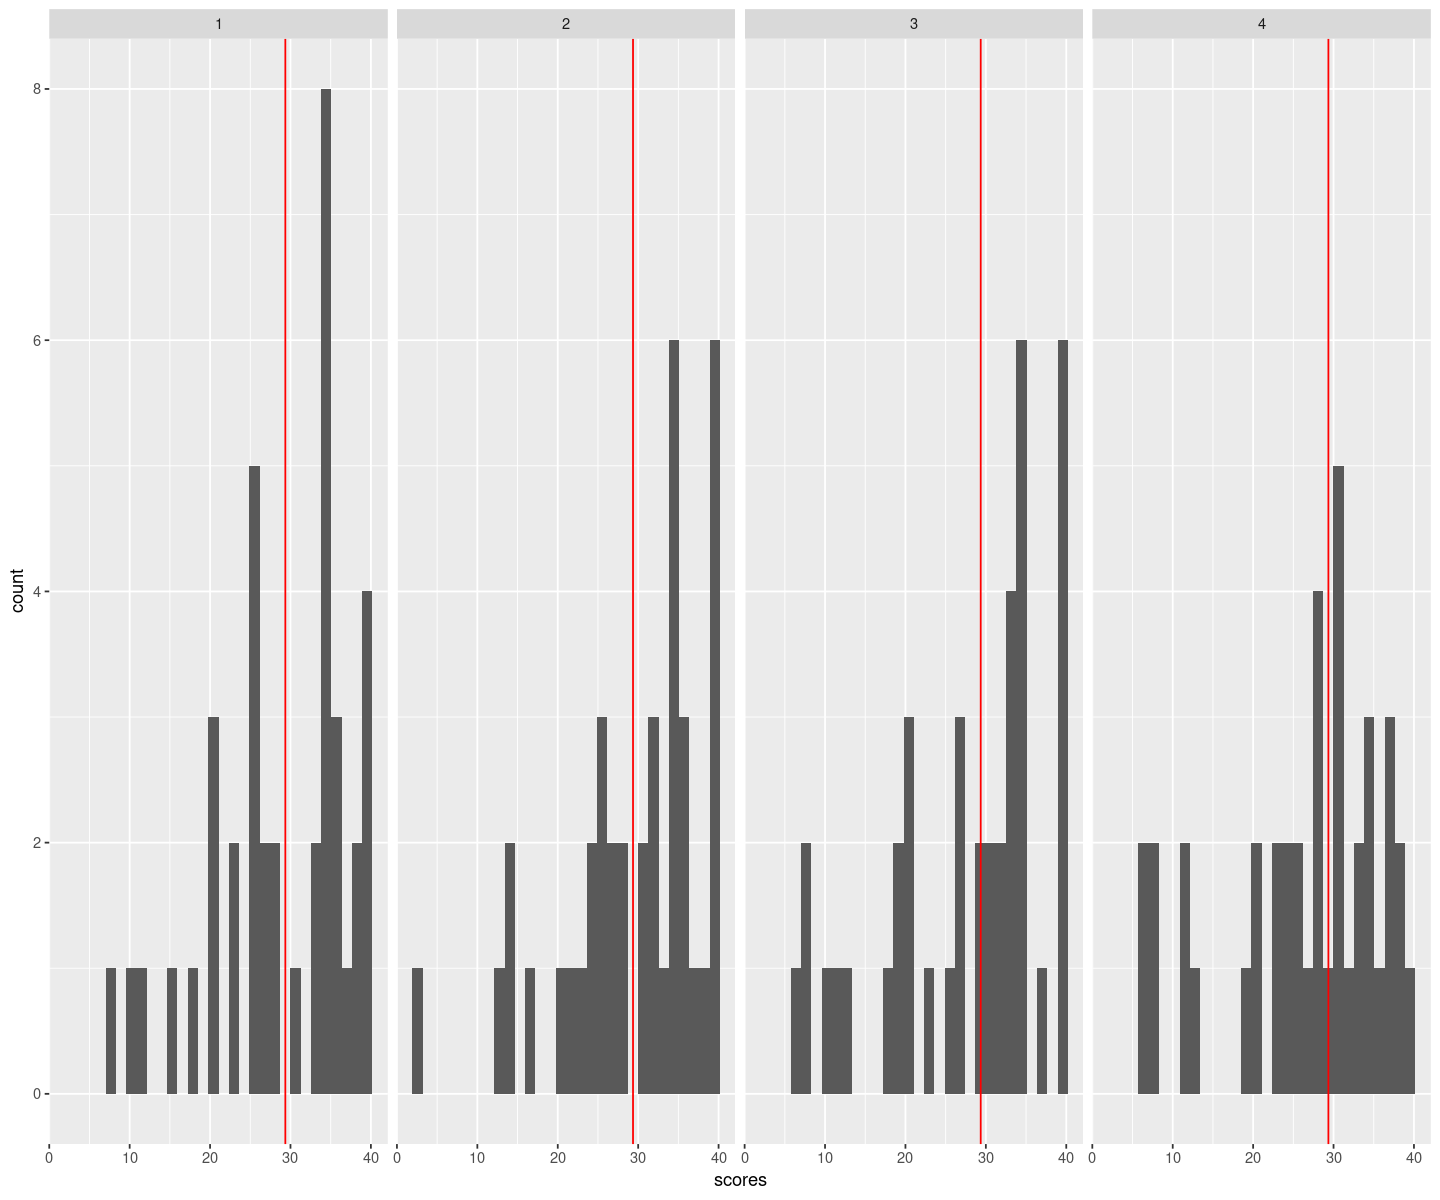

In [5]:
# Draw score distributions
#scores_df <- data.frame(draw_ind=0, scores=scores)
scores_df <- data.frame()
for (num_draws in c(10, 40, 100, 500)) {
  for (draw_ind in 1:100) {
    scores_df <- bind_rows(
      scores_df,
      data.frame(
        draw_ind=draw_ind, 
        num_draws=num_draws, 
        scores=draw_scores(num_draws)))
  }
}

scores_df <-
  scores_df %>%
  group_by(num_draws, draw_ind) %>%
  mutate(ybar=mean(scores))

score_means <- 
  scores_df %>%
  group_by(draw_ind, num_draws) %>%
  summarize(ybar=mean(scores))

# Showing the fact that different draws lead to different histrograms and different means
inner_join(scores_df, score_means, by=c("draw_ind", "num_draws")) %>%
  filter(draw_ind < 5, num_draws == 40) %>%
  ggplot() +
    geom_histogram(aes(x=scores)) +
    geom_vline(aes(xintercept=ybar), color="red") +
    facet_grid(~ draw_ind)



# The CLT and LLN

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8 rows containing missing values (`geom_bar()`).”

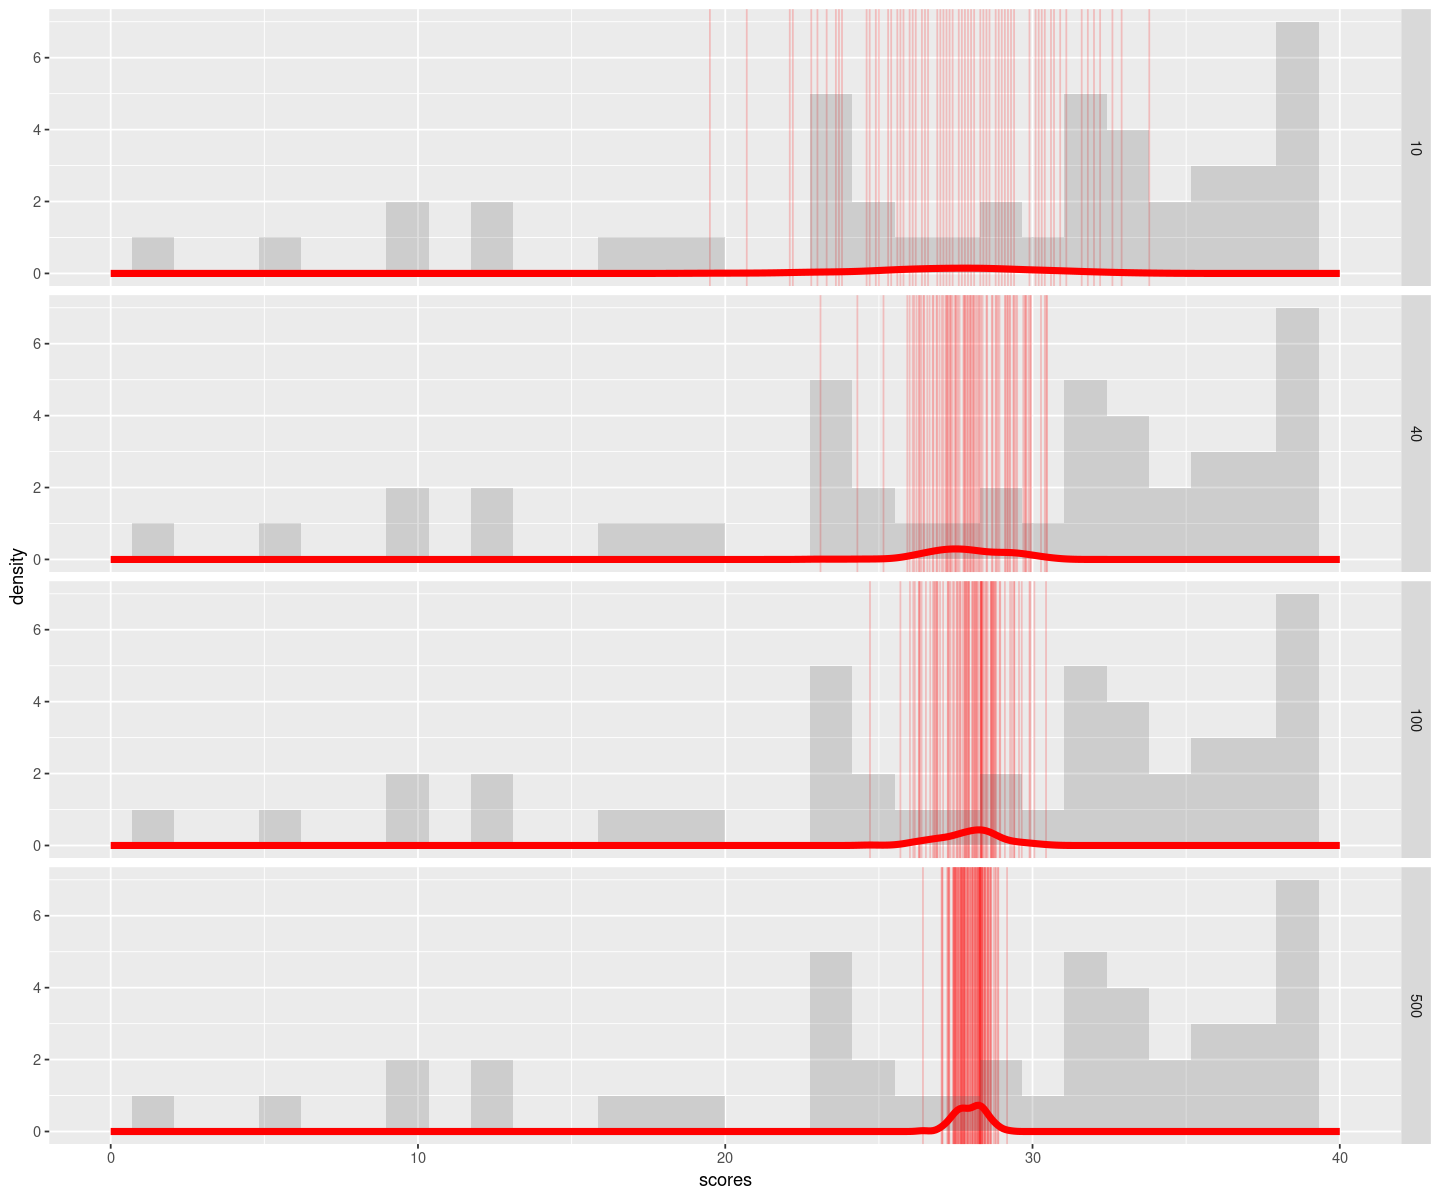

In [6]:
# The distribution of the score means for different numbers of draws
score_means %>%
  ggplot() +
    geom_vline(aes(xintercept=ybar), color="red", alpha=0.2) +
    geom_histogram(aes(x=scores), alpha=0.2, data=data.frame(scores=scores)) +
    geom_density(aes(x=ybar), color="red", lwd=2) +
    facet_grid(num_draws ~ .) +
    xlim(0, 40)
  

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 44 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 45 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 875 rows containing missing values (`geom_line()`).”

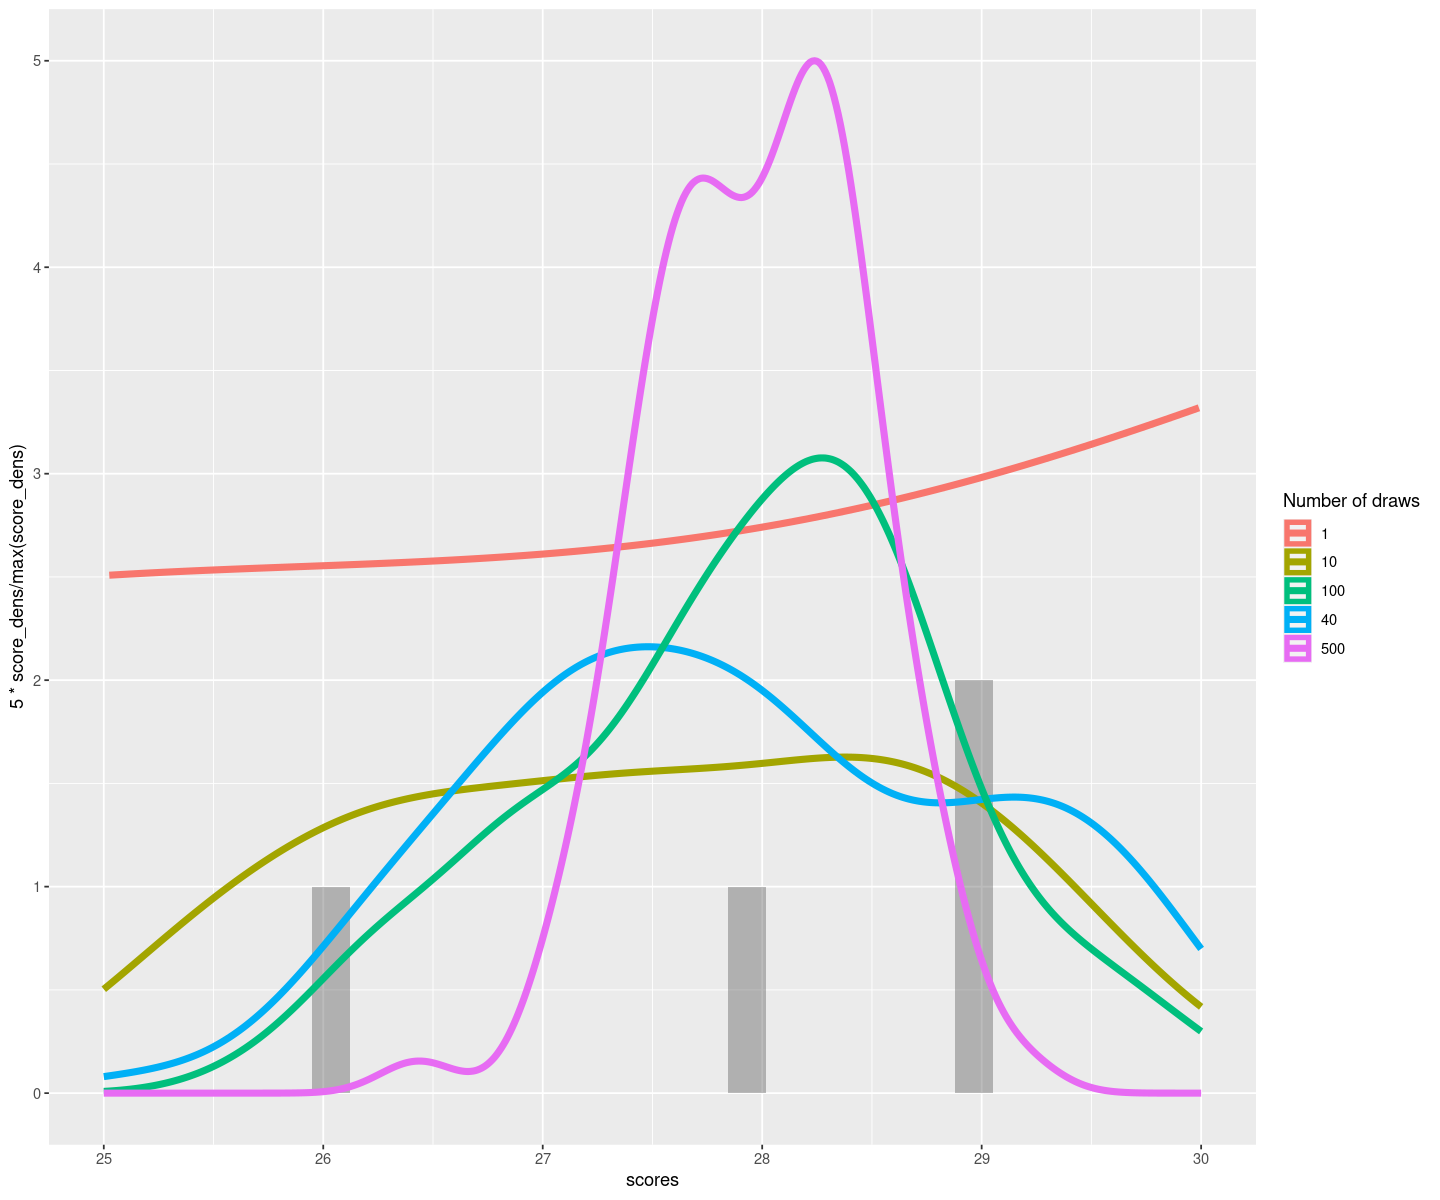

In [7]:
# The same plot with everything on the same panel
ggplot() + 
  geom_histogram(aes(x=scores), alpha=0.4) +
  geom_line(aes(x=score_grid, y=5 * score_dens / max(score_dens), color="1"), lwd=2) +
  geom_density(aes(x=ybar, y=..density.. * 5 / max(..density..), color=ordered(num_draws), group=num_draws), 
               data=score_means,
               lwd=2) +
  labs(color="Number of draws") +
  xlim(25, 30)

#ggplotly(p)

# Prediction

28.0258687403645

Warning message:
“Removed 750 rows containing missing values (`geom_line()`).”

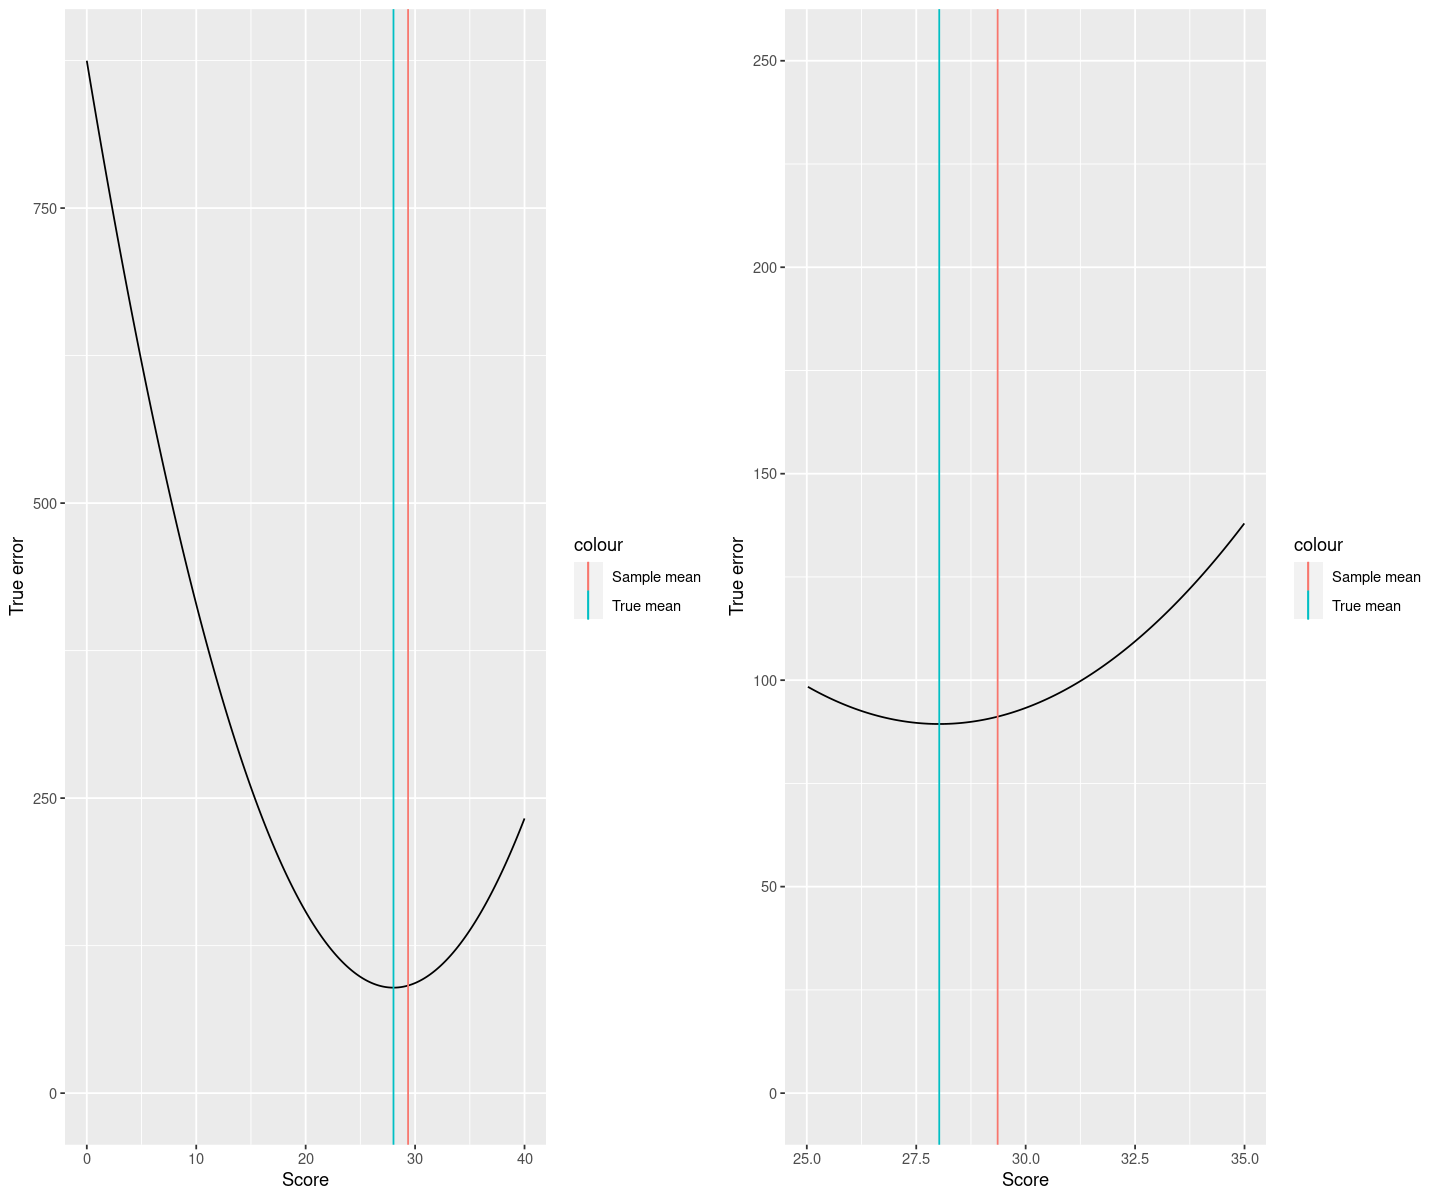

In [22]:
mean_true <- sum(score_dens * score_grid)
mean_true

eval_true_prediction_error <- function(score_guess) {
    return(sum(score_dens * (score_grid - score_guess)^2))
}

true_prediction_error <- sapply(score_grid, eval_true_prediction_error)

plt <-     
    ggplot() +
        geom_line(aes(x=score_grid, y=true_prediction_error)) +
        geom_vline(aes(xintercept=mean_true, color="True mean")) +
        geom_vline(aes(xintercept=ybar, color="Sample mean")) +
        xlab("Score") + ylab("True error") + expand_limits(y=0)
grid.arrange(plt, plt + xlim(25,35) + ylim(0, 250), ncol=2)


Warning message:
“Removed 750 rows containing missing values (`geom_line()`).”

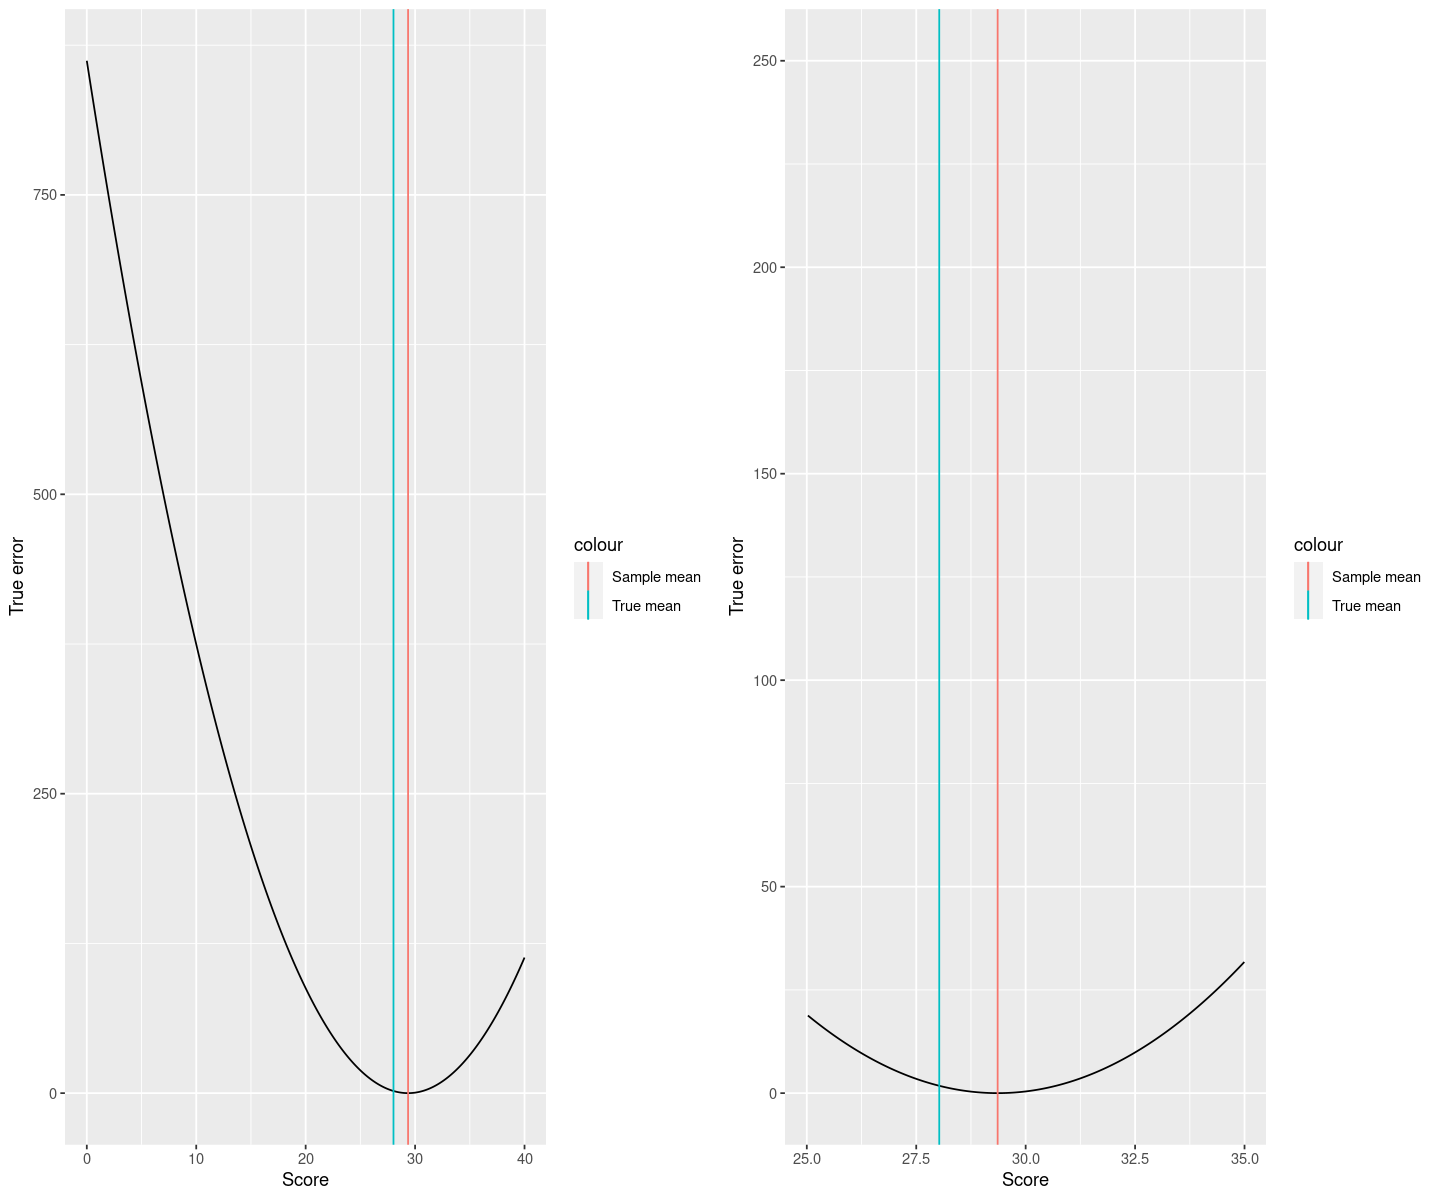

In [28]:

eval_sample_prediction_error <- function(score_guess, obs_scores) {
    return(mean(obs_scores - score_guess)^2)
}
sample_prediction_error <- sapply(score_grid, \(s) eval_sample_prediction_error(s, scores))

plt <-     
    ggplot() +
        geom_line(aes(x=score_grid, y=sample_prediction_error)) +
        geom_vline(aes(xintercept=mean_true, color="True mean")) +
        geom_vline(aes(xintercept=ybar, color="Sample mean")) +
        xlab("Score") + ylab("True error") + expand_limits(y=0)
grid.arrange(plt, plt + xlim(25,35) + ylim(0, 250), ncol=2)


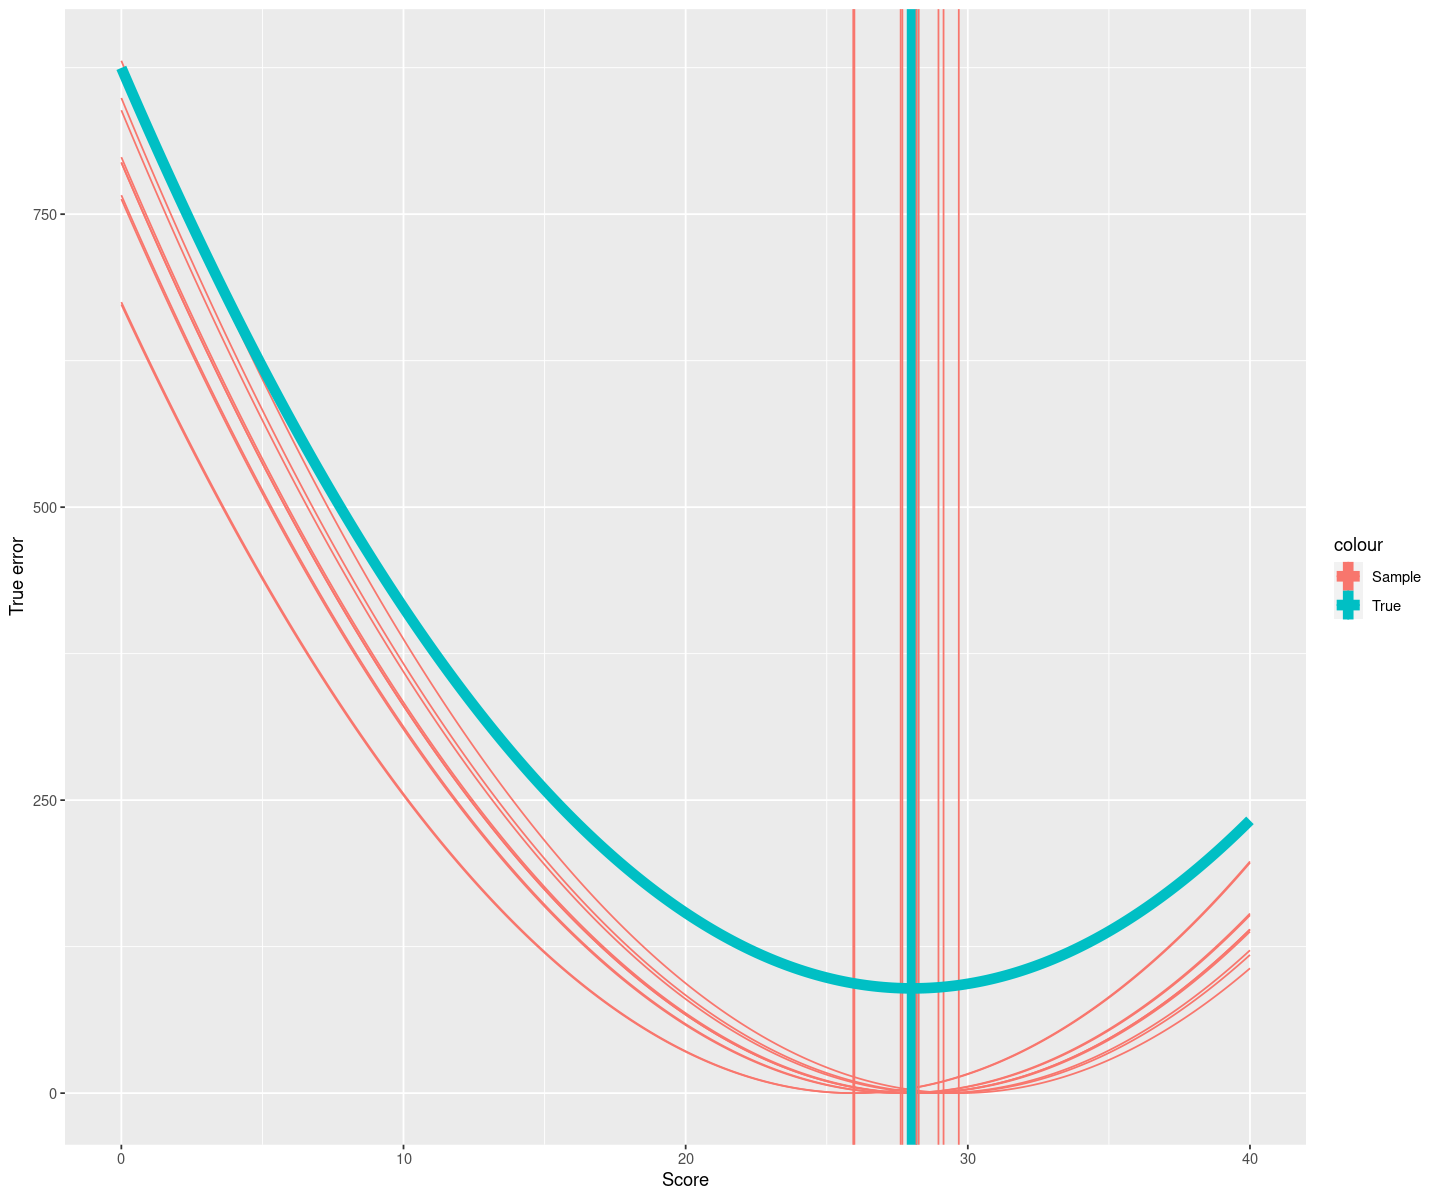

In [52]:
pred_df <- data.frame()
for (draw_ind in 1:10) {
    scores_draw <- draw_scores(length(scores))
    sample_prediction_error <- sapply(
        score_grid, \(s) eval_sample_prediction_error(s, scores_draw))

    pred_df <- bind_rows(
        pred_df,
        data.frame(
            score=score_grid,
            err=sample_prediction_error,
            sample_mean=mean(scores_draw),
            draw_ind=draw_ind))
}


ggplot() +
        geom_line(aes(x=score, y=err, group=draw_ind, color="Sample"), data=pred_df) +
        xlab("Score") + ylab("True error") + expand_limits(y=0) +
        geom_vline(aes(xintercept=mean_true, color="True"), lwd=3) +
        geom_vline(aes(xintercept=sample_mean, color="Sample"), data=pred_df) +
        geom_line(aes(x=score_grid, y=true_prediction_error, color="True"), lwd=3) 
